# Order-Agnostic Autoregressive Diffusion Models for Geostatistical Applications

## Introduction
Exploring for mineral or energy resources requires understanding the subsurface. 

The spatial distribution of these resources is critical to understanding how to efficiently extract critical resources, store energy, and potentially harmful greenhouse gases in subsurface reservoirs. 

Understanding these spatial distributions can help us to be more resource aware, economical, and safe in extraction or storage operations. 

Beyond understanding we may further wish to model the subsurface properties based on analogue examples, or conceptual models. 

Where data from direct observations such as boreholes or surface outcrops we may wish to include these to update our models so that they honor the available data. 

Due to the unknown nature of the precise spatial distribution of these properties away from the measurements we have to make assumptions about how these properties may vary in space (and sometimes time).

One possible way to do so, is to assume that the spatial distribution of subsurface properties is goverened by a random process, and so we build a statistical model which allows us to draw random samples, or models, of what the subsurface could look like. The field of geostatistics encompasses these and many more methods to perform statistical inference of spatial effects (not just subsurface material properties).

Here I will heavily make use of the work of others who have written and said much better than I could about a specific type of statistical model which has been a work horse of geostatistical applications and engineering in numerous geoscience domains. 



## Geostatistical Modeling

In geostatistical applications we often want to model the spatial distribution of properties such as the spatial distribution 
of the ore grade for a mineral resource or spatial distribution of porosities to store CO2 in the subsurface.

A common technique for generating spatial distributions of categorical (and with modification, continuous) properties
is so-called sequential indicator simulation (SIS).

[Gomez-Hernandez&Srivastasa](https://link.springer.com/article/10.1007/s11004-021-09926-0) provide an excellent review of 
sequential indicator simulation. 

In essence the idea, as they state, behind sequential indicator simulation is that any multidimensional random function can be 
represented as a product of univarite distributions by applying the rule of conditional probability:
$$F(Z(u_1), Z(u_2), ...., Z(u_n)) = F(Z(u_1)) F(Z(u_2)|Z(u_1)) ... F(Z(u_n)|Z(u_{n-1})Z(u_{n-2})...Z(u_2)Z(u_1))$$

Additionally, this sequence can be made conditional to existing data by determining the univariate probability distributions given the available data i.e. 
one essentially assumes you've already sampled a few of these values distributed in space and continues to generate a full realization from there.

In the case of SIS the probabilities for each indicator are obtained by kriging the probabilities at a new location $u_i$ being sampled 
and sampling from a the kriged probability univariate probability distribution conditional to all existing data and previously sampled locations.

The locations are sampled spatially in sequence by first generating a random path as a sequence for which we sample at every location
that we want to create a realization for.

The spatial distribution of the probabilities is obtained by experimental fitting of indicator variograms for each of the categories / indicator variables.

The sampling process is done step-by-step, grid-block by grid-block until we get a fully sampled realization that honors existing data.

This type of model, where we sequentially generate a realization variable-by-variable, step-by-step are often also called autoregressive models.


### Deep Generative Models
Generative modeling is the task of constructing or approximating data generating processes.
In a probabilistic sense we are attempting to build models of distributions of data. 

$$x\sim p(x)$$

In his upcoming book [Probabilistic Machine Learning: Advanced Topics](https://probml.github.io/pml-book/book2.html) [Kevin Patrick Murphy](Kevin Patrick Murphy)
has included an excellent chapter on so-called generative modeling. 

Numerous auto-regressive generative methods have been proposed, some of which use Deep Learning to learn the parameters of a generative model
from a large number of training images. 

The basic form that these autoregressive models take on is very similar to what we see in relation to SIS.
Taking from Murphy's book chapter 22 on autoregressive models, we can represent any multivariate probability distribution as a 
product of univariate conditional probabilities:

$$p(x_1, x_2, ..., x_{n-1}, x_{n})=p(x_1)p(x_2|x_1)...p(x_n|x_{n-1}, x_{n-2}, ..., x_2, x_1)$$

One such autoregressive model that uses deep learning to characterize this factorized conditional probability distribution 
are causal convolution models. These models learn to represent 1d, or 2d sequences over a multi-dimensional dataset such as 
audio (1d) or images (2d), by masking the convolutions to not take into account any variables that should not be involved in 
predicting the next variable in the sequence. 
<p align="center">
<img src="https://www.codeproject.com/KB/books/5061271/image003.gif" alt="PixelCNN" width="300"/></>

For example, we can sample a new tone in an audio file given only what has come before, and not what is after. To do so we must 
only take into account previous time-steps in our convolutions and requires masking any input data from later time steps.

An example of such a 1d causal convolutional model is the [wavenet]:
<p align="center">
<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-24_at_12.11.35_AM_uO4kv1I.png" alt="wavenet" width="300"/></>


Similarly we can conceive such causal convolutional models for images such as PixelCNN:
<p align="center">
<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/8e4ab54564fb492dcae9a1e862aedd3e52fb258b/2-Figure1-1.png" alt="pixelcnn" width="500"/></>

As can be seen, an image is interpreted as a sequence of variables each representing a pixel in the image, and the convolutions of a neural 
network only take into account pixels that have already been sampled.

And here comes the problem with respect to geostatistical applications: If we want to use such a model we can very certainly 
learn unconditional models that do not honor any existing data. For any practical purposes though we want to include
existing measurements at spatially distributed locations. 
<p align="center">
<img src="https://www.researchgate.net/profile/Marko-Maucec/publication/273259554/figure/fig5/AS:294756795076615@1447286904834/Conditioning-data-for-simulation-of-sandstone-black-and-shale-white-in-a_Q320.jpg" alt="from Srivastava 2013" width="200"/></>

(From Srivastava 2013, here the known data locations are shown as bold circles and unknonw in white)

If we wanted to include such data in the PixelCNN we'd have to 
create very elaborate or even (impossible?) masking schemes that would allow a convolutional network to take into account the spatial data
spread out over our study area. As of time of writing, I have not encountered such a model that is able to do this.

This is where I turn to a recent class of (deep) generative models called "Order-Agnostic" Autoregressive models which 
can potentially bridge this gap in application.

### Autoregressive Diffusion Models

Autoregressive diffusion models are a recently proposed method to build high-fidelity generative models of complex high-dimensional data distributions.

The approach combines ideas from other autoregressive models and so-called diffusion models. 

The basic idea is that instead of representing the entire sequence of autoregressive modeling by the output of say a CNN as is the case for PixelCNN, we parameterize an individual sampling step from a univariate probability distribution with a deep neural network. 

To tell the neural network where in the sampling process we are currently dealing with, we condition the input of the network by providing masks of the previously sampled data and only sample from the predicted univariate conditional distribution at the current sampling location. 

This is done exactly the same way as in SIS. We first define a random path through the model grid and then sequentially generate our realization. 

Instead of kriging probabilities for each new step, we feed the current state of the realization into the neural network together with the conditioning mask and then have the network predict the probabilities for our indicator variables. 

<p align="center">
<img src="https://pbs.twimg.com/media/FA-hqzMVcAkGi8j.jpg:large" alt="pixelcnn" width="500"/></>

(Taken from Hoogeboom et al 2021. Here sigma is the random sampling path.)

Here I only use binary examples but the approach generalizes to general categorical distributions. 

We can effectively train such a model on a set of training images by emulating the generation process i.e. for each training image we create a random path, and a random location where we assume from which we are sampling. 

Subsequently we train the network to maximize a variational lower bound on the exact log-likelihood of the training data given the current model parameters and hence the parameterization of the conditional probability distribution over the remaining sampling locations.

If you want to see all the details I suggest you read the series of tweets by Emiel [Tweet](https://twitter.com/emiel_hoogeboom/status/1488093915509104640?s=20&t=OGu4Z6vB6fmDMvS8zfak2A), read the paper [ArXiv](https://arxiv.org/abs/2110.02037), or watch this excellent video by Yannic Kilcher [Youtube](https://t.co/4tcUahFcM5)


### So what? How does this help?

This type of model assumes a distribution over random paths of generation hence we are not limited to very restrictive structures of our data generating process. 

This means when we want to create conditional images we can use these data and still obtain realizations that honor the known data locations. 

In my opinion, this opens up the door to geostatistical applications that require spatially distributed conditioning data. 

Furthermore, due to the probabilistic nature of the model we can also evaluate the uncertainty associated with observations.

This allows us to answer questions such as:  

*Given our assumption of the spatial data captured by a set of training images and the model trained on these images, what does the spatial uncertainty away from observations look like.*

### Guided Implementation

In the following I provide a detailed step by step walkthrough to train one of these models on two datasets.
- The MNIST dataset
- The Channels Training image published by [Eric Laloy and co-authors](https://github.com/elaloy/gan_for_gradient_based_inv)

In addition to that I provide demos for conditional image generation i.e. when we provide known data at arbitraty locations and can sample effectively images.

## Installing dependencies

In [ ]:
!pip install git+https://github.com/LukasMosser/order_agnostic_diffusion_geostats@main

## Checking for Availability and Status of GPU

In [2]:
!nvidia-smi

Wed Aug  3 06:14:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Logging into Weights & Biases for Monitoring (Optional)

In [3]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Import Libraries

In [67]:
%pylab inline
import itertools
import imageio
import os
import math
from tqdm.notebook import tqdm
import matplotlib.animation as animation
from IPython.display import HTML
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, OneHotCategorical
from torch.utils.data import TensorDataset
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda, Resize

import wandb
from huggingface_hub import hf_hub_download
from diffusers.models import UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers.training_utils import EMAModel
from accelerate import Accelerator, utils

Populating the interactive namespace from numpy and matplotlib


## Setting some (hyper-) parameters for the MNIST example

In [6]:
utils.set_seed(0)

batch_size = 128
w, h = 32, 32

transform = Compose([ToTensor(), Resize(w), lambda x: x>0.5])
train_dataset = MNIST(root=".", train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

model = UNet2DModel(
    sample_size=w,
    in_channels=2,
    out_channels=2,
    layers_per_block=2,
    block_out_channels=(64, 64, 128, 128),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

path = hf_hub_download(repo_id="porestar/oadg_mnist_32", filename="model.pt")

model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

accelerator = Accelerator(mixed_precision='fp16', log_with='wandb')
device = accelerator.device
model, train_dataloader = accelerator.prepare(model, train_dataloader)

model.eval()

UNet2DModel(
  (conv_in): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(

## Perform one sampling step from the model

### Sampling a Random Path (batched)

In [7]:
def sample_random_path(batch_size, w, h, device='cuda'):
    # Create a batch of random sampling paths
    random_path = torch.stack([torch.randperm(w * h, device=device, requires_grad=False) for _ in range(batch_size)],
                              axis=0)
    return random_path

sampled_random_path = sample_random_path(batch_size, w, h, device=device)

### Visualize the (batched) random paths

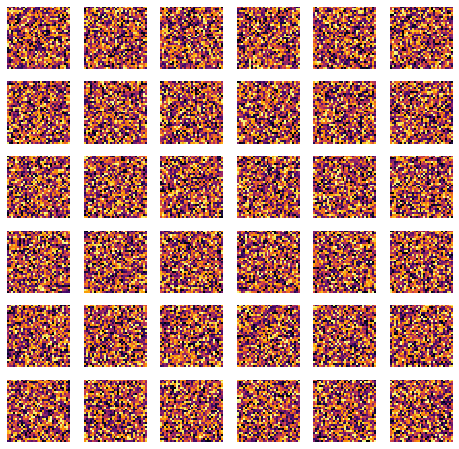

In [8]:
fig, ax = plt.subplots(6, 6, figsize=(8, 8))
for a, img in zip(ax.flatten(), sampled_random_path.cpu()):
  a.imshow(img.view(w, h), cmap="inferno", vmin=0, vmax=w*h, interpolation='none')
  a.set_axis_off()
plt.show()

### Create empty One-Hot Realization (0 - background, 1 - Foreground)

In [9]:
realization = torch.zeros(batch_size, 2, w, h, requires_grad=False, device=device).float()

### Create a linear index to step through random path

In [12]:
idx_range = torch.arange(start=0, end=w*h, step=1, device=device, requires_grad=False)


### Select the first index to sample -> index=0



In [13]:
idx = next(iter(idx_range))

### Create a mask with 1s where we've sampled already

In [15]:
def create_mask_at_random_path_index(sampled_random_path, idx, batch_size, w, h):
    # Create a mask that has 1s everywhere where we've sampled, and 0's everywhere else
    mask = (sampled_random_path < idx).view(batch_size, 1, w, h).long()
    return mask

mask = create_mask_at_random_path_index(sampled_random_path, idx, batch_size, w, h)

### Visualize mask

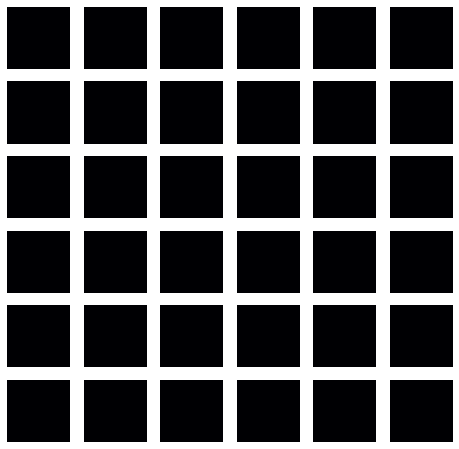

In [16]:
fig, ax = plt.subplots(6, 6, figsize=(8, 8))
for a, img in zip(ax.flatten(), mask.cpu()):
  a.imshow(img.view(w, h), cmap="inferno", vmin=0, vmax=1, interpolation='none')
  a.set_axis_off()
plt.show()

### Create a (batched) mask of where we are now sampling

In [17]:
def create_sampling_location_mask(sampled_random_path, idx, w, h):
    # Create a binary mask that as a 1 at the current location where we're sampling, and 0 otherwise
    sampling_location_mask = (sampled_random_path == idx).view(-1, 1, w, h).long()
    return sampling_location_mask

sampling_location_mask = create_sampling_location_mask(sampled_random_path, idx, w, h)

### Visualize where we are now sampling

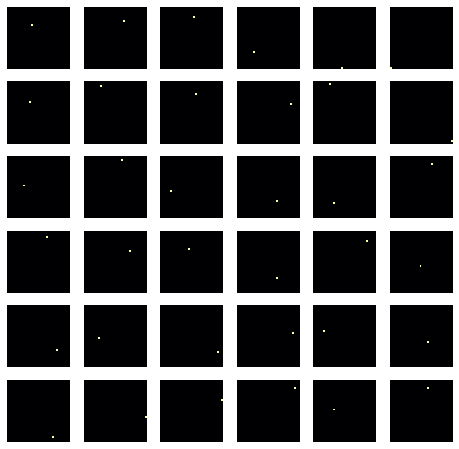

In [18]:
fig, ax = plt.subplots(6, 6, figsize=(8, 8))
for a, img in zip(ax.flatten(), sampling_location_mask.cpu()):
  a.imshow(img[0], cmap="inferno", vmin=0, vmax=1, interpolation='none')
  a.set_axis_off()
plt.show()

### Let's get the conditional distribution at these locations

In [19]:
def predict_conditional_prob(realization, model, sampling_location_mask, idx):
    # We paramterize the Categorical Distribution by the output of our neural network.
    # The outputs are a one-hot-categorical distribution from which we can sample
    logits = F.log_softmax(model(sampling_location_mask * realization, idx.view(-1, ))['sample'], dim=1)
    conditional_prob = OneHotCategorical(logits=logits.permute(0, 2, 3, 1))
    return conditional_prob

with torch.inference_mode():
  conditional_prob = predict_conditional_prob(realization, model, sampling_location_mask, idx)

### We sample from this conditional probability distribution

In [20]:
def sample_from_conditional(conditional_prob):
    # Draw a sample from the categorical distribution
    return conditional_prob.sample().permute(0, 3, 1, 2)

sampled_realization = sample_from_conditional(conditional_prob)

### Visualizing the resulting sample

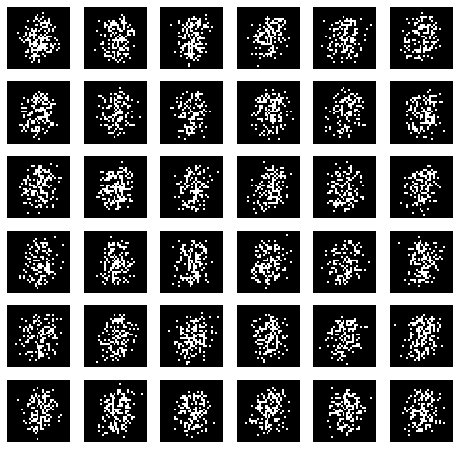

In [22]:
fig, ax = plt.subplots(6, 6, figsize=(8, 8))
for a, img in zip(ax.flatten(), torch.argmax(sampled_realization.cpu(), dim=1)):
  a.imshow(img, cmap="gray", vmin=0, vmax=1, interpolation='none')
  a.set_axis_off()
plt.show()

### Combine realization with predicted value at current path location

In [23]:
def insert_predicted_value_at_sampling_location(realization, sampled_realization, sampling_location_mask):
    # combine the current state of the realization with the newly predicted value
    realization = (1 - sampling_location_mask) * realization + sampling_location_mask * sampled_realization
    return realization

realization = insert_predicted_value_at_sampling_location(realization, sampled_realization, sampling_location_mask)

### Visualizing the updated realization

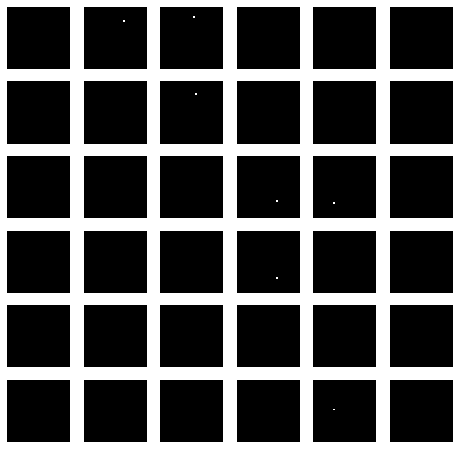

In [24]:
fig, ax = plt.subplots(6, 6, figsize=(8, 8))
for a, img in zip(ax.flatten(), torch.argmax(realization.cpu(), dim=1)):
  a.imshow(img, cmap="gray", vmin=0, vmax=1, interpolation='none')
  a.set_axis_off()
plt.show()

### Computing the entropy of the conditional distribution

In [25]:
def compute_entropy(conditional_prob):
    # We can directly compute the entropy of the Categorical Distribution
    return conditional_prob.entropy().unsqueeze(1)

conditional_entropy = compute_entropy(conditional_prob)

### Visualizing the entropy of the conditional distribution

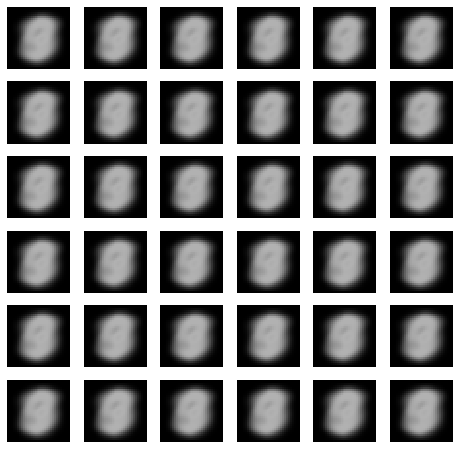

In [26]:
def binary_entropy(p, eps=1e-6):
  h = -p*np.log2(p+eps)-(1-p)*np.log2(1-p)
  
  if np.isnan(h):
    return eps
  return h

fig, ax = plt.subplots(6, 6, figsize=(8, 8))
for a, img in zip(ax.flatten(), conditional_entropy.cpu()):
  a.imshow(img[0], cmap="gray", vmin=binary_entropy(0), vmax=binary_entropy(0.5), interpolation='none')
  a.set_axis_off()
plt.show()

### Take the argmax of the one-hot realizaiton to get the realization

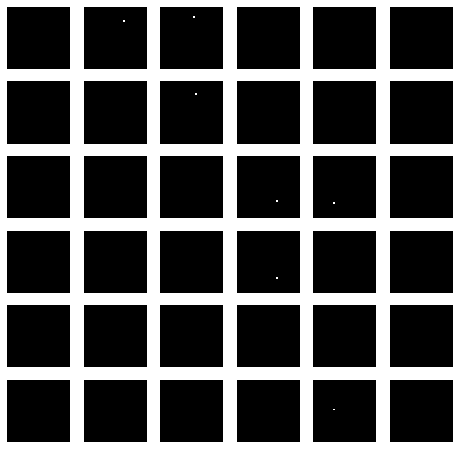

In [27]:
realization = torch.argmax(realization, dim=1, keepdim=True).cpu()

fig, ax = plt.subplots(6, 6, figsize=(8, 8))
for a, img in zip(ax.flatten(), realization.cpu()):
  a.imshow(img[0], cmap="gray", vmin=0, vmax=1, interpolation='none')
  a.set_axis_off()
plt.show()

## Putting it all together - Sampling a Realization

In [29]:
realizations = []
entropys = []

# We sample a batch of random paths
sampled_random_path = sample_random_path(batch_size, w, h, device=device)

# Define an empty set of realizations we're going to fill
realization = torch.zeros(batch_size, 2, w, h, requires_grad=False, device=device).float()

# A linear increasing sampling index
idx_range = torch.arange(start=0, end=w*h, step=1, device=device, requires_grad=False)

progress_bar = tqdm(idx_range, total=len(idx_range))
for idx in progress_bar:

  # We mask all locations we've already sampled
  mask = create_mask_at_random_path_index(sampled_random_path, idx, batch_size, w, h)

  # We mask where we are currently sampling
  sampling_location_mask = create_sampling_location_mask(sampled_random_path, idx, w, h)

  # Fast prediction without computing any gradients
  with torch.inference_mode():

    # We obtain the univariate conditional distribution parameterized by our deep neural network
    conditional_prob = predict_conditional_prob(realization, model, mask, idx)
  
  # We sample from this conditional distribution
  sampled_realization = sample_from_conditional(conditional_prob)

  # And update our current state of our realization
  realization = insert_predicted_value_at_sampling_location(realization, sampled_realization, sampling_location_mask)

  # Also computing analytically the entropy of the conditional probability distribution for all locations
  conditional_entropy = compute_entropy(conditional_prob)

  # Saving these images for the animations
  realizations.append(torch.argmax(realization, dim=1).cpu().numpy())
  entropys.append(conditional_entropy.cpu().numpy())

  progress_bar.set_description("Generating Sample. Step: {0:}".format(idx))

  0%|          | 0/1024 [00:00<?, ?it/s]

### Visualizing the generation of a sample realization

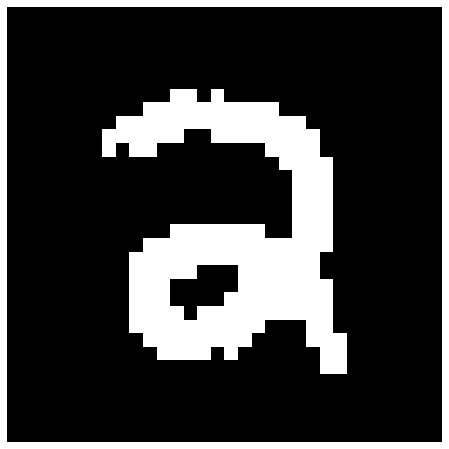

In [30]:
#%%capture
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.reshape(i[0], (w, h)), animated=True, cmap='gray', vmin=0, vmax=1)] for i in realizations[::10]]
ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### Visualizing the change in entropy for a batch of samples during sampling

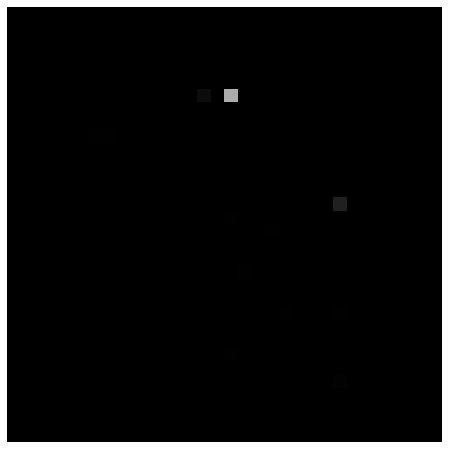

In [31]:
#%%capture
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.reshape(i[0], (w, h)), animated=True, cmap='gray', vmin=0, vmax=1)] for i in entropys[::10]]
ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Wrapping the sampling steps in a function

In [61]:
def initialize_empty_realizations_and_paths(batch_size, w, h, device='cpu'):
    """
    We create the necessary sampling paths, each random for each bach element.
    """
    random_paths = []
    for _ in range(batch_size):

        # Linear increasing index steps for sampling paths.
        random_path = np.arange(w * h)

        # Shuffle the index array to create a sampling path throughout the realization
        np.random.shuffle(random_path)

        random_paths.append(random_path)

    random_paths = np.array(random_paths)

    # We start from an empty realization so we start at index 0 for generating samples x1 \sim p(x_1)
    idx_start = 0
    random_paths = torch.from_numpy(random_paths).to(device)
    realization = torch.zeros((batch_size, 1, h, w)).to(device)

    return idx_start, random_paths, realization



def sample_realization(model, image_size: int = 32, batch_size: int = 16,
           realization=None, idx_start=0, random_paths=None, device='cpu'):
    # Set the model into eval mode
    model.eval()

    w, h = image_size, image_size
    if realization is not None:
        w, h = realization.size()[-2:]

    # One-hot our realization before sampling
    realization = torch.cat([1 - realization, realization], dim=1).float()

    # Create the sampling index range, starts not from 0 in case there's conditioning data
    idx_range = torch.arange(start=idx_start, end=w * h, step=1, device=device, requires_grad=False)

    # Iterate over incrementing steps, will predict based on random path
    for idx in tqdm(idx_range):

        # Create a mask to indicate locations where we've already sampled
        mask = create_mask_at_random_path_index(random_paths, idx, batch_size, w, h)

        # Create a mask to indicate where we are currently sampling
        sampling_location_mask = create_sampling_location_mask(random_paths, idx, w, h)

        # use inference mode to speed up prediction of univariate conditional distribution for current sampling location
        with torch.inference_mode():
            conditional_prob = predict_conditional_prob(realization, model, mask, idx)

        # sample a value based on predicted univariate conditional distribution
        sampled_realization = sample_from_conditional(conditional_prob)

        # update the realization with the newly sampled pixel
        realization = insert_predicted_value_at_sampling_location(realization, sampled_realization,
                                                                  sampling_location_mask)

    # return the binary realization
    return torch.argmax(realization, dim=1).cpu().numpy()

idx_start, random_paths, realization = initialize_empty_realizations_and_paths(batch_size, w, h, device=device)
realization = sample_realization(model, batch_size=batch_size, realization=realization, idx_start=idx_start, random_paths=random_paths, image_size=h, device=device)

  0%|          | 0/1024 [00:00<?, ?it/s]

## Training the Order-Agnostic Autoregressive Model

### Sample a batch of training images

In [36]:
realization, _ = next(iter(train_dataloader))
realization = realization.float()

### One-Hot the Realization

In [37]:
def one_hot_realization(realization):
    # We one-hot the binary image as an input to the neural network
    realization = torch.cat([1 - realization, realization], dim=1)
    return realization

realization = one_hot_realization(realization)
print(realization.size())

torch.Size([128, 2, 32, 32])


### Sample a set of random paths

In [38]:
sampled_random_path = sample_random_path(batch_size, w, h, device=device)

### Sample random indices where we're gonna sample next

In [39]:
def sample_random_index_for_sampling(batch_size, w, h, device='cuda'):
    # Sample a random index where we want to sample next
    idx = torch.randint(low=0, high=w * h + 1, size=(batch_size, 1, 1), device=device, requires_grad=False)
    return idx

idx = sample_random_index_for_sampling(batch_size, w, h, device=device)

### Create a mask from a random path

In [41]:
random_path_mask = create_mask_at_random_path_index(sampled_random_path.view(-1, w, h), idx, batch_size, w, h)

### Compute the conditional probabilities

In [42]:
conditional_prob = predict_conditional_prob(realization, model, random_path_mask, idx)

### Compute log probability of the realization

In [43]:
def log_prob_of_realization(conditional_prob, realization):
    # Compute the log-probability of a given realization
    log_prob = conditional_prob._categorical.log_prob(torch.argmax(realization, dim=1))
    return log_prob
    
log_prob = log_prob_of_realization(conditional_prob, realization)

### Compute log probability at unsampled locations

In [44]:
def log_prob_of_unsampled_locations(log_prob, sampling_location_mask):
    # Compute the total log probability of the unsampled locations, taking sum over log-probs
    log_prob_unsampled = ((1 - sampling_location_mask) * log_prob).sum(dim=(1, 2, 3))
    return log_prob_unsampled

log_prob_unsampled = log_prob_of_unsampled_locations(log_prob, sampling_location_mask)

### Compute reweighted loss

In [47]:
def weight_log_prob(log_prob_unsampled, idx, w, h):
    # We compute the average log-probability over the unsampled locations
    log_prob_weighted = 1 / (w * h - idx + 1) * log_prob_unsampled
    return log_prob_weighted

log_prob_weighted = weight_log_prob(log_prob_unsampled, idx, w, h)


### Compute average loss over batch of realizations

In [48]:
def compute_average_loss_for_batch(log_prob_weighted):
    # We compute a (negative) average over the batch elements to compute an unbiased estimator of the loss
    loss = -log_prob_weighted.mean()
    return loss

model.zero_grad()
loss = compute_average_loss_for_batch(log_prob_weighted)
print("Loss: {0:.3f}".format(loss.detach().item()))

Loss: 54.057


### Computing gradients of the loss with respect to model parameters

In [49]:
accelerator.backward(loss)
accelerator.clip_grad_norm_(model.parameters(), 100.0)

### Defining the ELBO objective

In [51]:
def elbo_objective(model, realization, device='cuda'):
    """
    Computing the Evidence Lower Bound (Elbo) Objective for the ARDM model

    We are going to have our model minimize the average negative log-likelihood predicted for
    random unsampled locations in a batch of training examples.

    We want our model to predict a high-likelihood for the true values at those unsampled locations.
    """
    batch_size, _, w, h = realization.size()

    # Get a batch of random sampling paths
    sampled_random_path = sample_random_path(batch_size, w, h, device=device)

    # Sample a set of random sampling steps for each individual training image in the current batch
    idx = sample_random_index_for_sampling(batch_size, w, h, device=device)

    # We create a mask that masks the locations where we assume we've already sampled
    random_path_mask = create_mask_at_random_path_index(sampled_random_path.view(-1, w, h), idx, batch_size, w, h)

    # We predict the conditional probability for the current sampling step for each training image in the batch
    # Image 1: log p(x23 | x22, x21, x20, ..., x1)
    # Image 2: log p(5 | x4, x3, x2, x1)
    conditional_prob = predict_conditional_prob(realization, model, random_path_mask, idx)

    # Evaluate the value of the log probability for the given realization
    log_prob = log_prob_of_realization(conditional_prob, realization)

    # Compute the total log probability of the unsampled locations
    log_prob_unsampled = log_prob_of_unsampled_locations(log_prob, random_path_mask)

    # Compute an average over all the unsampled locations for each image in the batch
    log_prob_weighted = weight_log_prob(log_prob_unsampled, idx, w, h)

    # Compute an average loss i.e. negative average log likelihood over the batch elements
    loss = compute_average_loss_for_batch(log_prob_weighted)

    return loss

### Putting all the steps together for a single forward and backward pass

In [52]:
# Zero all the gradients on the model's paramters
model.zero_grad()

# Sample a batch of training images and one-hot them
realization = next(iter(train_dataloader))[0].float()
realization = one_hot_realization(realization)

# Compute the elbo objective to get the loss
loss = elbo_objective(model, realization, device=device)

# compute gradients of the loss w.r.t. to the model parameters
accelerator.backward(loss)

# clip the gradient norm as done in the paper
accelerator.clip_grad_norm_(model.parameters(), 100.0)
print("Loss: {0:.3f}".format(loss.detach().item()))

Loss: 13.192


### Defining the model, gradient descent optimizer, learning rate scheduler, and the exponential moving average operator

In [55]:
# we set the random seed to make it reproducible
utils.set_seed(0)

# we initialize a model
model = UNet2DModel(
    sample_size=w,
    in_channels=2,
    out_channels=2,
    layers_per_block=2,
    block_out_channels=(64, 64, 128, 128),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

# we initialize loss monitoring
accelerator.init_trackers('autoregressive-models')

# set the model into train mode
model.train()

# we use the adamW optimizer to perform stochastic gradient descent
optimizer = optim.AdamW(model.parameters(), 
                        lr=3e-4, 
                        weight_decay=1e-6)

# we use a cosine learning rate schedule with a linear warmup
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=(len(train_dataloader) * 1),
)

# huggingface accelerate handles some optimizations to put things on the right device
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

# we use an exponential moving average of the model parameters to get better performance
ema = EMAModel(model, inv_gamma=1.0, power=0.75, max_value=0.999)

## Train the MNIST Autoregressive Diffusion Model for 100 gradient descent steps

In [57]:
global_step = 0
total_steps = 100

progress_bar = tqdm(range(total_steps))
for realization, _ in itertools.cycle(train_dataloader):
  realization = one_hot_realization(realization.float())

  optimizer.zero_grad()
  
  loss = elbo_objective(model, realization, device=device)
  accelerator.backward(loss)
  accelerator.clip_grad_norm_(model.parameters(), 100.0)

  global_step += 1
  lr_scheduler.step()
  optimizer.step()
  ema.step(model)

  logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
  accelerator.log(logs, step=global_step)
  
  progress_bar.set_description("Step {0:}, Loss: {1:.2f}, Learning Rate: {2:.3e}".format(logs['step'], logs['loss'], logs['lr']))
  progress_bar.update(1)

  if global_step > total_steps:
    break

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### Sample from the Exponential Moving Average Model

In [62]:
idx_start, random_paths, realization = initialize_empty_realizations_and_paths(batch_size, w, h, device=device)
realization = sample_realization(accelerator.unwrap_model(ema.averaged_model), 
                     batch_size=batch_size, realization=realization, idx_start=idx_start, random_paths=random_paths, 
                     image_size=h, device=device)

  0%|          | 0/1024 [00:00<?, ?it/s]

### Visualize obtained realizations after training

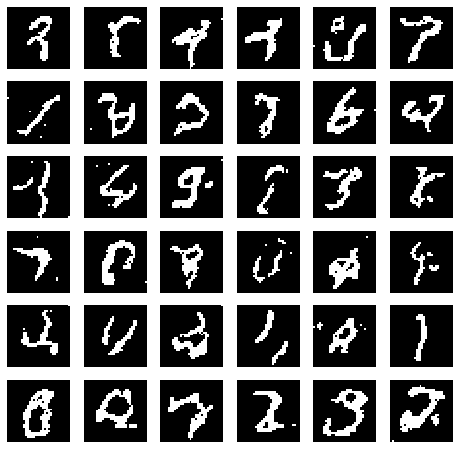

In [65]:
fig, ax = plt.subplots(6, 6, figsize=(8, 8))
for a, img in zip(ax.flatten(), realization):
  a.imshow(img, cmap="gray", vmin=0, vmax=1, interpolation='none')
  a.set_axis_off()
plt.show()

## Training the Autoregressive Diffusion Model on MNIST Dataset

### Collecting all necessary steps and logging in a function

In [68]:
def train(model, optimizer, lr_scheduler, train_dataloader,
          accelerator,
          ema, total_steps, max_grad_norm, path: Path, fname,
          save_every, device='cuda'):

    progress_bar = tqdm(range(total_steps), total=total_steps)

    global_step = 0

    # We use an enumeration of the dataloader to continuously sample from the dataloader without epochs
    for realization in itertools.cycle(train_dataloader):

        if isinstance(realization, list):
            # Handle datasets with labels, assumes image first, label second.
            realization = realization[0]

        optimizer.zero_grad()

        if global_step % save_every == 0:
            torch.save(accelerator.unwrap_model(ema.averaged_model).state_dict(),
                       path.joinpath(fname + "_step_{0:}.pth".format(global_step)))

        # One-hot the batch of training images
        realization = one_hot_realization(realization.float())

        # Compute the elbo loss for the batch of training images
        loss = elbo_objective(model, realization, device=device)

        # Backpropagate the loss to the parameters of the model
        accelerator.backward(loss)

        # We clip the norm of the parameters of the model as in the paper
        accelerator.clip_grad_norm_(model.parameters(), max_grad_norm)

        # Increment the global step and learning rate scheduler
        global_step += 1
        lr_scheduler.step()

        # Make a stochastic gradient descent step using the estimated gradients of the loss w.r.t. the parameters
        optimizer.step()

        # Update the exponential moving average of weights as in the publication
        ema.step(model)

        # Log the loss to the monitor
        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        accelerator.log(logs, step=global_step)

        progress_bar.set_description(
            "Step {0:}, Loss: {1:.2f}, Learning Rate: {2:.3e}".format(logs['step'], logs['loss'], logs['lr']))
        progress_bar.update(1)

        if global_step == total_steps:
            break

### Setting the hyper-parameters for final model training

In [71]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 32  # the generated image resolution
    train_batch_size = 128
    total_steps = 1000
    gradient_accumulation_steps = 1
    learning_rate = 3e-4
    lr_warmup_steps = 100
    weight_decay = 1e-6
    ema_inv_gamma = 1.0
    ema_power = 0.75
    ema_max_value = 0.999
    max_grad_norm = 100.0
    save_every = 10
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    seed = 0

config = TrainingConfig()

### Inititalizing and training the final MNIST model

In [73]:
config = TrainingConfig()

utils.set_seed(config.seed)

batch_size = config.train_batch_size
w, h = config.image_size, config.image_size

transform = Compose([ToTensor(), Resize(w), lambda x: x>0.5])
train_dataset = MNIST(root=".", train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

model = UNet2DModel(
    sample_size=w,
    in_channels=2,
    out_channels=2,
    layers_per_block=2,
    block_out_channels=(64, 64, 128, 128),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

accelerator = Accelerator(mixed_precision=config.mixed_precision, log_with='wandb')
accelerator.init_trackers('order-agnostic-autoregressive-diffusion-mnist')
device = accelerator.device

optimizer = optim.AdamW(model.parameters(), 
                        lr=config.learning_rate, 
                        weight_decay=config.weight_decay)


lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=config.total_steps,
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

ema = EMAModel(model, inv_gamma=config.ema_inv_gamma, power=config.ema_power, max_value=config.ema_max_value)

In [75]:
train(model, optimizer, lr_scheduler, train_dataloader, accelerator, ema, 
      config.total_steps, config.max_grad_norm, Path("."), "mnist",
      config.save_every, device=device)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Sampling Conditional Realizations

### Defining the conditioning data

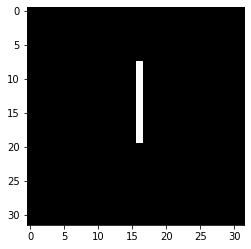

In [94]:
w, h = 32, 32
conditioning_data = np.zeros((w, h)).astype(int)
conditioning_data[8:20, 16:16+1] = 1

plt.imshow(conditioning_data, cmap="gray", vmin=0, vmax=1)
plt.show()

### Finding the indices of the conditioning data location

In [97]:
# We turn the conditioning data into a vector
flattened_img = conditioning_data.flatten()

# And we find those locations where we have conditioning data (only foreground supported right now)
conditioning_indices = np.argwhere(flattened_img > 0)[:, 0]

# And wehere we don't have any conditioning data
unconditioned_indices = np.argwhere(flattened_img < 1)[:, 0]

### Creating random paths for a set of sampled conditioned realizations

In [98]:
# Generate random paths for each batch element
random_paths = []
for _ in range(batch_size):
    # We need to take into account that we're predicting after n conditioning data
    random_path = np.arange(len(conditioning_indices), w * h)
    np.random.shuffle(random_path)

    # Placeholder for the path
    random_path_grid = np.zeros((w, h)).reshape(-1)

    # Where we have the conditioning data we set the indices to a range of n_0 to n_conditioning data
    random_path_grid[conditioning_indices] = np.arange(len(conditioning_indices))

    # and for the remaining locations we have an incremental randomized random path
    random_path_grid[unconditioned_indices] = random_path

    random_paths.append(random_path_grid)

random_paths = np.array(random_paths)

### Visualizing the conditioned random sampling paths

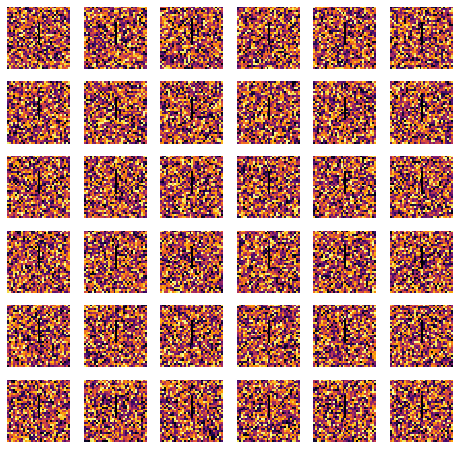

In [99]:
fig, ax = plt.subplots(6, 6, figsize=(8, 8))
for a, img in zip(ax.flatten(), random_paths):
  a.imshow(img.reshape(w, h), cmap="inferno", vmin=0, vmax=w*h, interpolation='none')
  a.set_axis_off()
plt.show()

### Initializing the conditioned realizations and sampling steps

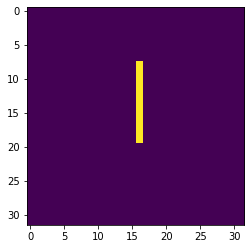

In [100]:
# We start sampling starting after the conditioning data
idx_start = np.sum(flattened_img)

# Move everything to torch
random_paths = torch.from_numpy(random_paths).to(device)
realization = torch.from_numpy(conditioning_data).view(1, 1, h, w).to(device)

# One-hot the starting realization
realization = torch.cat([1-realization, realization], dim=1).float()

plt.imshow(realization.cpu()[0, 1])
plt.show()

### Sample from conditional data

In [101]:
# Set the model into eval mode
model.eval()

realizations = []
entropys = []

# Create the sampling index range, starts not from 0 in case there's conditioning data
idx_range = torch.arange(start=idx_start, end=w * h, step=1, device=device, requires_grad=False)

# Iterate over incrementing steps, will predict based on random path
for idx in tqdm(idx_range):

  # Create a mask to indicate locations where we've already sampled
  mask = create_mask_at_random_path_index(random_paths, idx, batch_size, w, h)

  # Create a mask to indicate where we are currently sampling
  sampling_location_mask = create_sampling_location_mask(random_paths, idx, w, h)

  # use inference mode to speed up prediction of univariate conditional distribution for current sampling location
  with torch.inference_mode():
    conditional_prob = predict_conditional_prob(realization, model, mask, idx)

  # sample a value based on predicted univariate conditional distribution
  sampled_realization = sample_from_conditional(conditional_prob)

  # update the realization with the newly sampled pixel
  realization = insert_predicted_value_at_sampling_location(realization, sampled_realization,
                                                          sampling_location_mask)

  conditional_entropy = compute_entropy(conditional_prob)

  realizations.append(torch.argmax(realization, dim=1).cpu().numpy())
  entropys.append(conditional_entropy.cpu().numpy())

  0%|          | 0/1012 [00:00<?, ?it/s]

### Visualize Conditional Sample Generation

Sampling Step 0


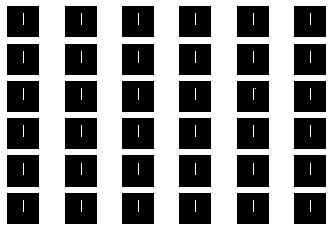

Sampling Step 300


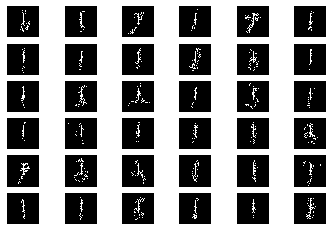

Sampling Step 800


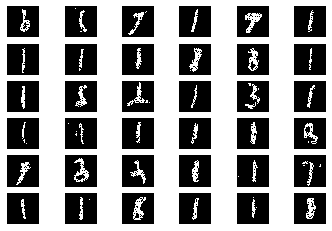

Sampling Step 1011


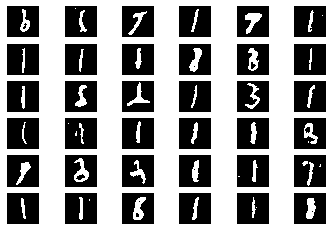

In [102]:
for idx in [0, 300, 800, len(idx_range)-1]:
  print("Sampling Step {0:}".format(idx))
  fig, ax = plt.subplots(6, 6)
  for a, img in zip(ax.flatten(), realizations[idx]):
    a.imshow(img.reshape(w, h), cmap="gray", vmin=0, vmax=1)
    a.set_axis_off()
  plt.show()

### Visualizing Conditional Entropy during Sample Generation

Sampling Step 0


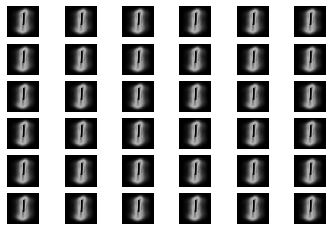

Sampling Step 300


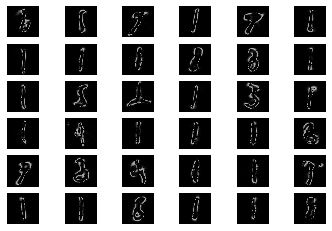

Sampling Step 800


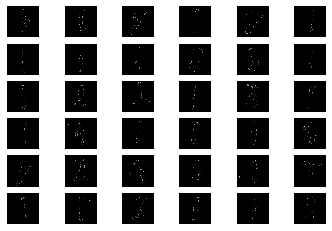

Sampling Step 1011


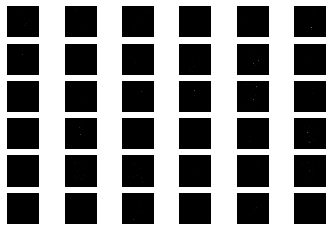

In [103]:
for idx in [0, 300, 800, len(idx_range)-1]:
  print("Sampling Step {0:}".format(idx))
  fig, ax = plt.subplots(6, 6)
  for a, img in zip(ax.flatten(), entropys[idx]):
    a.imshow(img.reshape(w, h), cmap="gray", vmin=0, vmax=1)
    a.set_axis_off()
  plt.show()

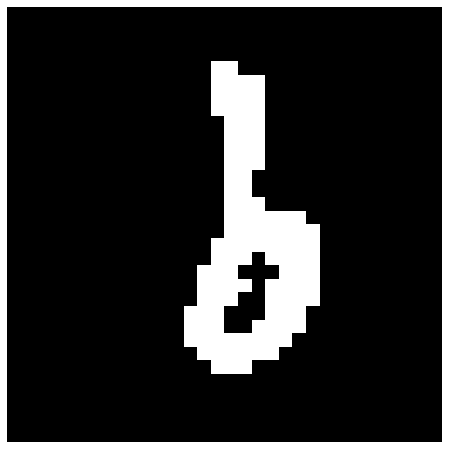

In [104]:
#%%capture
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.reshape(i[0], (w, h)), animated=True, cmap='gray', vmin=0, vmax=1)] for i in realizations[::10]]
ani = animation.ArtistAnimation(fig, ims, interval=10, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### Visualize Conditional Sample Generation Entropy

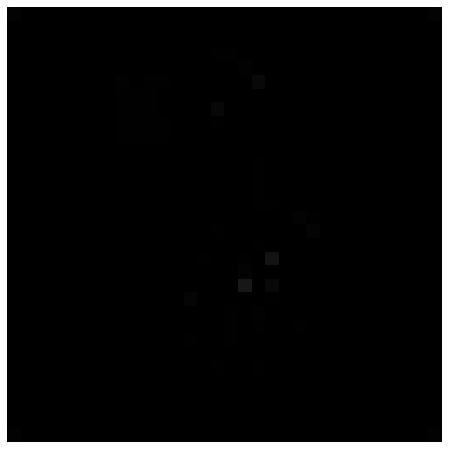

In [105]:
#%%capture
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.reshape(i[0], (w, h)), animated=True, cmap='gray', vmin=0, vmax=1)] for i in entropys[::10]]
ani = animation.ArtistAnimation(fig, ims, interval=10, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### Making functions that allows us to later sample conditionally

In [107]:
def make_conditional_paths_and_realization(conditioning_data, batch_size=16, device='cpu'):
    """
    Create random sampling paths that honor conditioning data
    """
    w, h = conditioning_data.shape

    # We turn the conditioning data into a vector
    flattened_img = conditioning_data.flatten()

    # And we find those locations where we have conditioning data (only foreground supported right now)
    conditioning_indices = np.argwhere(flattened_img > 0)[:, 0]

    # And wehere we don't have any conditioning data
    unconditioned_indices = np.argwhere(flattened_img < 1)[:, 0]

    # Generate random paths for each batch element
    random_paths = []
    for _ in range(batch_size):
        # We need to take into account that we're predicting after n conditioning data
        random_path = np.arange(len(conditioning_indices), w * h)
        np.random.shuffle(random_path)

        # Placeholder for the path
        random_path_grid = np.zeros((w, h)).reshape(-1)

        # Where we have the conditioning data we set the indices to a range of n_0 to n_conditioning data
        random_path_grid[conditioning_indices] = np.arange(len(conditioning_indices))

        # and for the remaining locations we have an incremental randomized random path
        random_path_grid[unconditioned_indices] = random_path

        random_paths.append(random_path_grid)

    random_paths = np.array(random_paths)

    # We start sampling starting after the conditioning data
    idx_start = np.sum(flattened_img)

    random_paths = torch.from_numpy(random_paths).to(device)
    realization = torch.from_numpy(conditioning_data).view(1, 1, h, w).to(device)

    return idx_start, random_paths, realization

idx_start, random_paths, realization = make_conditional_paths_and_realization(conditioning_data, batch_size, device=device)
conditioned_samples_mnist = sample_realization(model, batch_size=batch_size, realization=realization, idx_start=idx_start, random_paths=random_paths, image_size=h, device=device)

  0%|          | 0/1012 [00:00<?, ?it/s]

### Visualizing the resulting conditioned samples

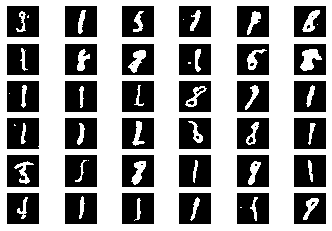

In [108]:
fig, ax = plt.subplots(6, 6)
for a, img in zip(ax.flatten(), conditioned_samples_mnist):
  a.imshow(img.reshape(w, h), cmap="gray", vmin=0, vmax=1)
  a.set_axis_off()
plt.show()

## Training the order-agnostic autoregressive diffusion model on a training image of a river channel system

### Downloading the training image

In [109]:
!wget https://raw.githubusercontent.com/elaloy/gan_for_gradient_based_inv/master/training/ti/ti.png

--2022-08-03 07:53:35--  https://raw.githubusercontent.com/elaloy/gan_for_gradient_based_inv/master/training/ti/ti.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144022 (141K) [image/png]
Saving to: ‘ti.png’

ti.png              100%[===================>] 140.65K  --.-KB/s    in 0.008s  

2022-08-03 07:53:35 (18.3 MB/s) - ‘ti.png’ saved [144022/144022]



### Let's visualize the training image

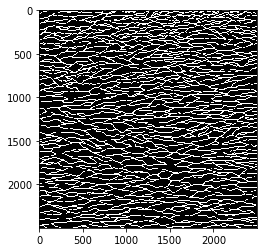

In [114]:
ti = imageio.imread('ti.png')

plt.imshow(ti, vmin=0, vmax=255, interpolation="none", cmap="gray")
plt.show()

### Extracting training sub-patches from a large training image

In [115]:
def extract_patches(img, patch_size=64, stride=16, flip_up_down=False, flip_left_right=False, mirror=False):
  patches = []
  for i in range(0, img.shape[0]-patch_size, 16):
    for j in range(0, img.shape[1]-patch_size, 16):
      patches.append(img[i:i+patch_size, j:j+patch_size])
  patches = np.array(patches)
  all_patches = [patches]
  if flip_up_down:
    all_patches.append(patches[..., ::-1, :])
  if flip_left_right:
    all_patches.append(patches[..., :, ::-1])
  if mirror:
    all_patches.append(patches[..., ::-1, ::-1])
  patches = np.concatenate(all_patches, axis=0)
  return patches

patch_size = (64, 64)
stride = 16

train_patches = extract_patches(ti, patch_size=patch_size[0], stride=stride, flip_up_down=True, mirror=True, flip_left_right=True)

train_patches = torch.from_numpy(train_patches).unsqueeze(1)

train_dataset = TensorDataset(train_patches/255., torch.zeros(train_patches.size(0), 1))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)


### Let's visualize a batch of training images

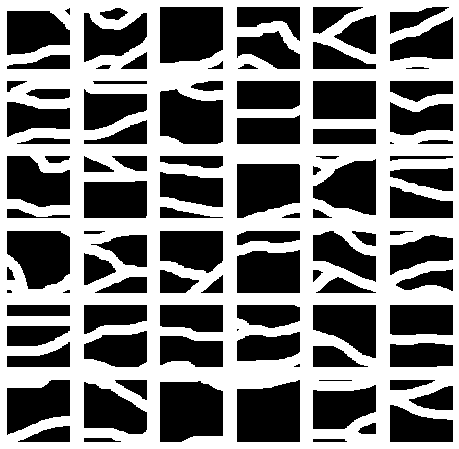

In [116]:
images, _ = next(iter(train_dataloader))

fig, ax = plt.subplots(6, 6, figsize=(8, 8))
for a, img in zip(ax.flatten(), images.cpu()):
  a.imshow(img[0], cmap="gray", vmin=0, vmax=1, interpolation='none')
  a.set_axis_off()
plt.show()

## Setting the Hyper-Parameters

In [118]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 64  # the generated image resolution
    train_batch_size = 64
    total_steps = 1000
    gradient_accumulation_steps = 1
    learning_rate = 3e-4
    lr_warmup_steps = 100
    weight_decay = 1e-6
    ema_inv_gamma = 1.0
    ema_power = 0.75
    ema_max_value = 0.999
    max_grad_norm = 100.0
    save_every = 100
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    seed = 0

### Inititalizing the Model, Optimizer, and Scheduler

In [122]:
config = TrainingConfig()

utils.set_seed(config.seed)

batch_size = config.train_batch_size
w, h = config.image_size, config.image_size

transform = Compose([ToTensor(), Resize(w), lambda x: x>0.5])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

model = UNet2DModel(
    sample_size=w,
    in_channels=2,
    out_channels=2,
    layers_per_block=2,
    block_out_channels=(64, 64, 128, 128),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

accelerator = Accelerator(mixed_precision=config.mixed_precision, log_with='wandb')
accelerator.init_trackers('order-agnostic-autoregressive-diffusion-channels')
device = accelerator.device

optimizer = optim.AdamW(model.parameters(), 
                        lr=config.learning_rate, 
                        weight_decay=config.weight_decay)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=config.total_steps)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

ema = EMAModel(model, inv_gamma=config.ema_inv_gamma, power=config.ema_power, max_value=config.ema_max_value)

In [123]:
train(model, optimizer, lr_scheduler, train_dataloader, accelerator, ema, 
      config.total_steps, config.max_grad_norm, Path("."), "channels",
      config.save_every, device=device)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Generating conditional channel images from the trained model

### Loading the trained weights of the model

In [127]:
model.load_state_dict(torch.load("./channels_step_900.pth"))
model.eval()

UNet2DModel(
  (conv_in): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(

### Setting the conditioning data

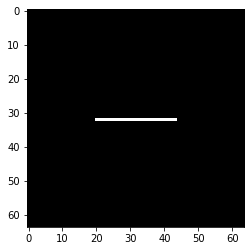

In [128]:
conditioning_data = np.zeros((64, 64)).astype(int)
conditioning_data[32, 20:-20] = 1

plt.imshow(conditioning_data, vmin=0, vmax=1, cmap="gray", interpolation="none")
plt.show()

### Making random sampling paths

In [129]:
idx_start, random_paths, realization = make_conditional_paths_and_realization(conditioning_data, batch_size, device=device)

### Sampling conditional data

In [131]:
# One-hot the starting realization
realization = torch.cat([1-realization, realization], dim=1).float()

# Set the model into eval mode
model.eval()

realizations = []
entropys = []

# Create the sampling index range, starts not from 0 in case there's conditioning data
idx_range = torch.arange(start=idx_start, end=w * h, step=1, device=device, requires_grad=False)

# Iterate over incrementing steps, will predict based on random path
for idx in tqdm(idx_range):

  # Create a mask to indicate locations where we've already sampled
  mask = create_mask_at_random_path_index(random_paths, idx, batch_size, w, h)

  # Create a mask to indicate where we are currently sampling
  sampling_location_mask = create_sampling_location_mask(random_paths, idx, w, h)

  # use inference mode to speed up prediction of univariate conditional distribution for current sampling location
  with torch.inference_mode():
    conditional_prob = predict_conditional_prob(realization, model, mask, idx)

  # sample a value based on predicted univariate conditional distribution
  sampled_realization = sample_from_conditional(conditional_prob)

  # update the realization with the newly sampled pixel
  realization = insert_predicted_value_at_sampling_location(realization, sampled_realization,
                                                          sampling_location_mask)

  conditional_entropy = compute_entropy(conditional_prob)

  realizations.append(torch.argmax(realization, dim=1).cpu().numpy())
  entropys.append(conditional_entropy.cpu().numpy())

  0%|          | 0/4072 [00:00<?, ?it/s]

### Visualizing the generation of the samples in the batch

Sampling Step 0


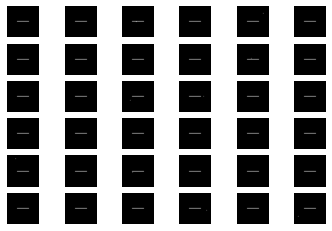

Sampling Step 1000


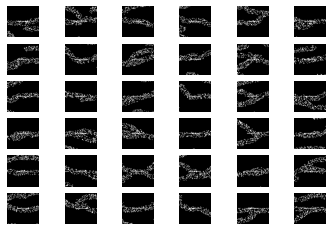

Sampling Step 2500


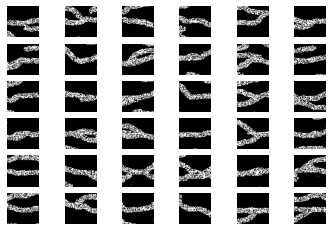

Sampling Step 4071


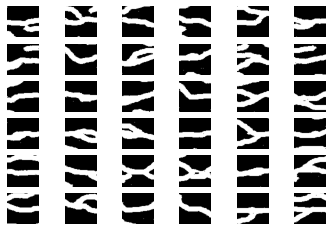

In [132]:
for idx in [0, 1000, 2500, len(idx_range)-1]:
  print("Sampling Step {0:}".format(idx))
  fig, ax = plt.subplots(6, 6)
  for a, img in zip(ax.flatten(), realizations[idx]):
    a.imshow(img.reshape(w, h), cmap="gray", vmin=0, vmax=1)
    a.set_axis_off()
  plt.show()

### Visualizing the entropy during generation of a batch of samples

Sampling Step 0


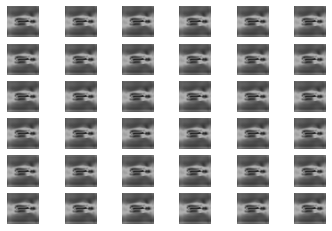

Sampling Step 1000


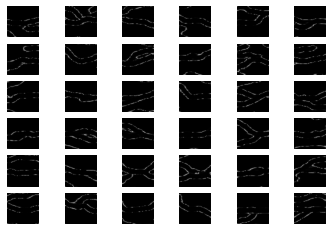

Sampling Step 2500


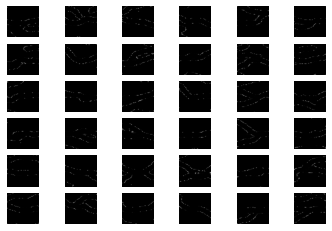

Sampling Step 4071


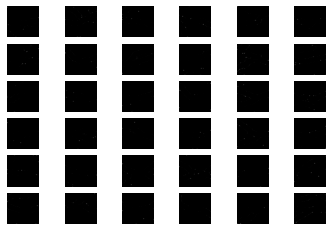

In [133]:
for idx in [0, 1000, 2500, len(idx_range)-1]:
  print("Sampling Step {0:}".format(idx))
  fig, ax = plt.subplots(6, 6)
  for a, img in zip(ax.flatten(), entropys[idx]):
    a.imshow(img.reshape(w, h), cmap="gray", vmin=0, vmax=1)
    a.set_axis_off()
  plt.show()

### Visualizing the generation for a single example

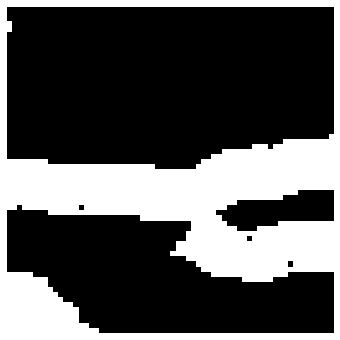

In [134]:
fig = plt.figure(figsize=(6, 6))
plt.axis("off")
ims = [[plt.imshow(np.reshape(i[0], (w, h)), animated=True, cmap='gray', vmin=0, vmax=1)] for i in realizations[::50]]
ani = animation.ArtistAnimation(fig, ims, interval=10, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### Visualizing the entropy for generation of a single example

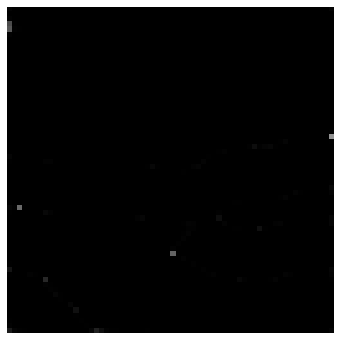

In [135]:
fig = plt.figure(figsize=(6, 6))
plt.axis("off")
ims = [[plt.imshow(np.reshape(i[0], (w, h)), animated=True, cmap='gray', vmin=0, vmax=1)] for i in entropys[::20]]
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())